In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Model fitting with correlated noise 

This notebook was made with the following version of george:

In [2]:
import george
george.__version__

'0.3.1.dev0'

In this example, we’re going to simulate a common data analysis situation where our dataset exhibits unknown correlations in the noise. When taking data, it is often possible to estimate the independent measurement uncertainty on a single point (due to, for example, Poisson counting statistics) but there are often residual systematics that correlate data points. The effect of this correlated noise can often be hard to estimate but ignoring it can introduce substantial biases into your inferences. In the following sections, we will consider a synthetic dataset with correlated noise and a simple non-linear model. We will start by fitting the model assuming that the noise is uncorrelated and then improve on this model by modeling the covariance structure in the data using a Gaussian process.


## A Simple Mean Model

The model that we’ll fit in this demo is a single Gaussian feature with three parameters: amplitude $\alpha$, location $\ell$, and width $\sigma^2$. I’ve chosen this model because is is the simplest non-linear model that I could think of, and it is qualitatively similar to a few problems in astronomy (fitting spectral features, measuring transit times, etc.).


## Simulated Dataset

Let's start by simulating a dataset of 50 points with known correlated noise. In fact, this example is somewhat artificial since the data were drawn from a Gaussian process but in everything that follows, we’ll use a different kernel function for our inferences in an attempt to make the situation slightly more realistic. A known white variance was also added to each data point.

Using the parameters

$$\alpha = −1 \quad, \quad\quad \ell = 0.1 \quad, \quad\quad \sigma^2 = 0.4 \quad.$$

the resulting dataset is:

In [3]:
from george.modeling import Model

class Model(Model):
    parameter_names = ("amp", "location", "log_sigma2")
    
    def get_value(self, t):
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))

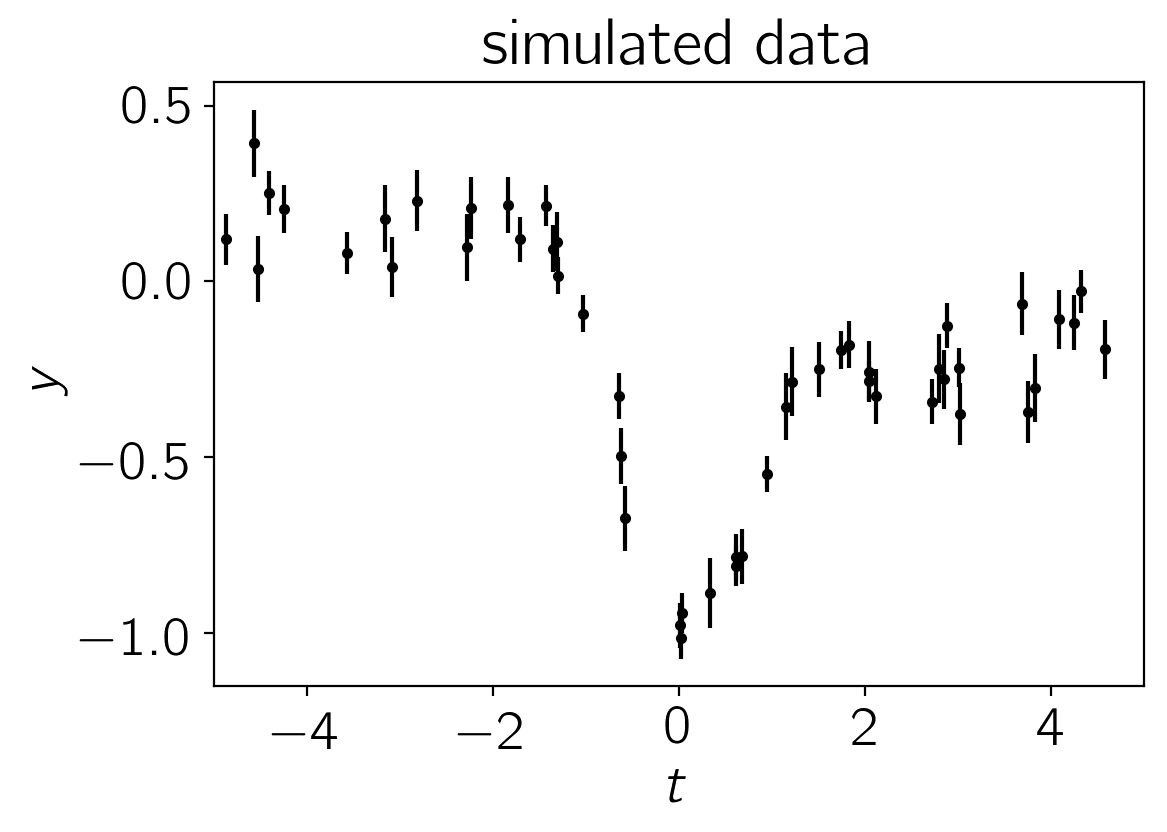

In [4]:
import numpy as np
import matplotlib.pyplot as pl
from george import kernels

np.random.seed(1234)

def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    return t, y, yerr

truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
t, y, yerr = generate_data(truth, 50)

pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("simulated data");

## Assuming White Noise

Let's start by doing the standard thing and assuming that the noise is
uncorrelated.
In this case, the ln-likelihood function of the data $\{y_n\}$ given the
parameters $\theta$ is

$$
    \ln p(\{y_n\}\,|\,\{t_n\},\,\{\sigma_n^2\},\,\theta) =
        -\frac{1}{2}\,\sum_{n=1}^N \frac{[y_n - f_\theta(t_n)]^2}{\sigma_n^2}
        + A
$$

where $A$ doesn't depend on $\theta$ so it is irrelevant for our
purposes and $f_\theta(t)$ is our model function.

It is clear that there is some sort of systematic trend in the data and we
don't want to ignore that so we'll simultaneously model a linear trend and the
Gaussian feature described in the previous section.
Therefore, our model is

$$
    f_\theta (t) = m\,t + b +
        \alpha\,\exp\left(-\frac{[t-\ell]^2}{2\,\sigma^2} \right)
$$

where $\theta$ is the 5-dimensional parameter vector

$$
    \theta = \{ m,\,b,\,\alpha,\,\ell,\,\sigma^2 \} \quad.
$$

The following code snippet is a simple implementation of this model in Python.

In [5]:
class PolynomialModel(Model):
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")
    
    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b +
                self.amp * np.exp(-0.5*(t-self.location)**2*np.exp(-self.log_sigma2)))

To fit this model using MCMC (using [emcee](http://dfm.io/emcee)), we need to first choose priors—in this case we’ll just use a simple uniform prior on each parameter—and then combine these with our likelihood function to compute the ln-probability (up to a normalization constant). In code, this will be:

In [6]:
model = george.GP(mean=PolynomialModel(m=0, b=0, amp=-1, location=0.1, log_sigma2=np.log(0.4)))
model.compute(t, yerr)

def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()

Now that we have our model implemented, we’ll initialize the walkers and run both a burn-in and production chain:

In [7]:
import emcee

initial = model.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running burn-in...
Running production...


After running the chain, we can plot the predicted results. It is often useful to plot the results on top of the data as well. To do this, we can over plot 24 posterior samples on top of the data:

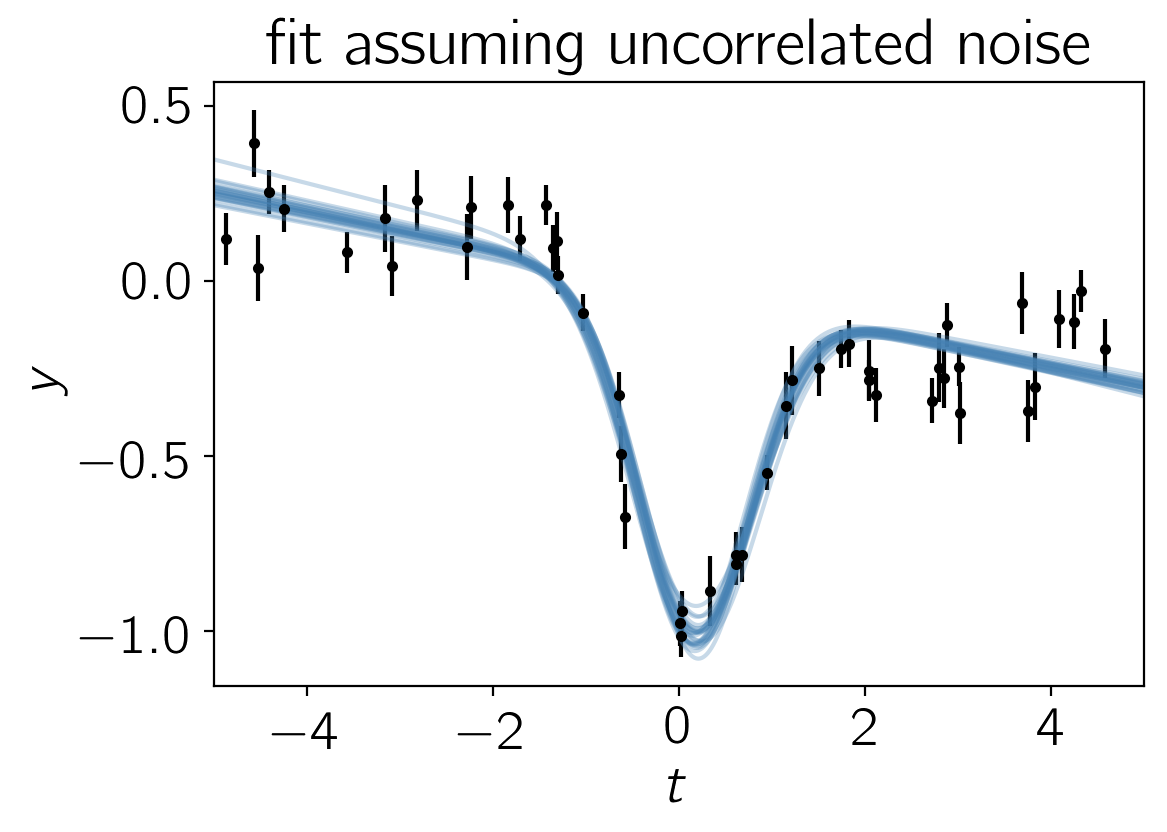

In [8]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    model.set_parameter_vector(s)
    pl.plot(x, model.mean.get_value(x), color="#4682b4", alpha=0.3)
    
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("fit assuming uncorrelated noise");

In this figure, the data are shown as black points with error bars and the posterior samples are shown as translucent blue lines. These results seem, at face value, pretty satisfying. But, since we know the true model parameters that were used to simulate the data, we can assess our original assumption of uncorrelated noise. To do this, we’ll plot all the projections of our posterior samples using [corner.py](https://github.com/dfm/corner.py) and over plot the true values:

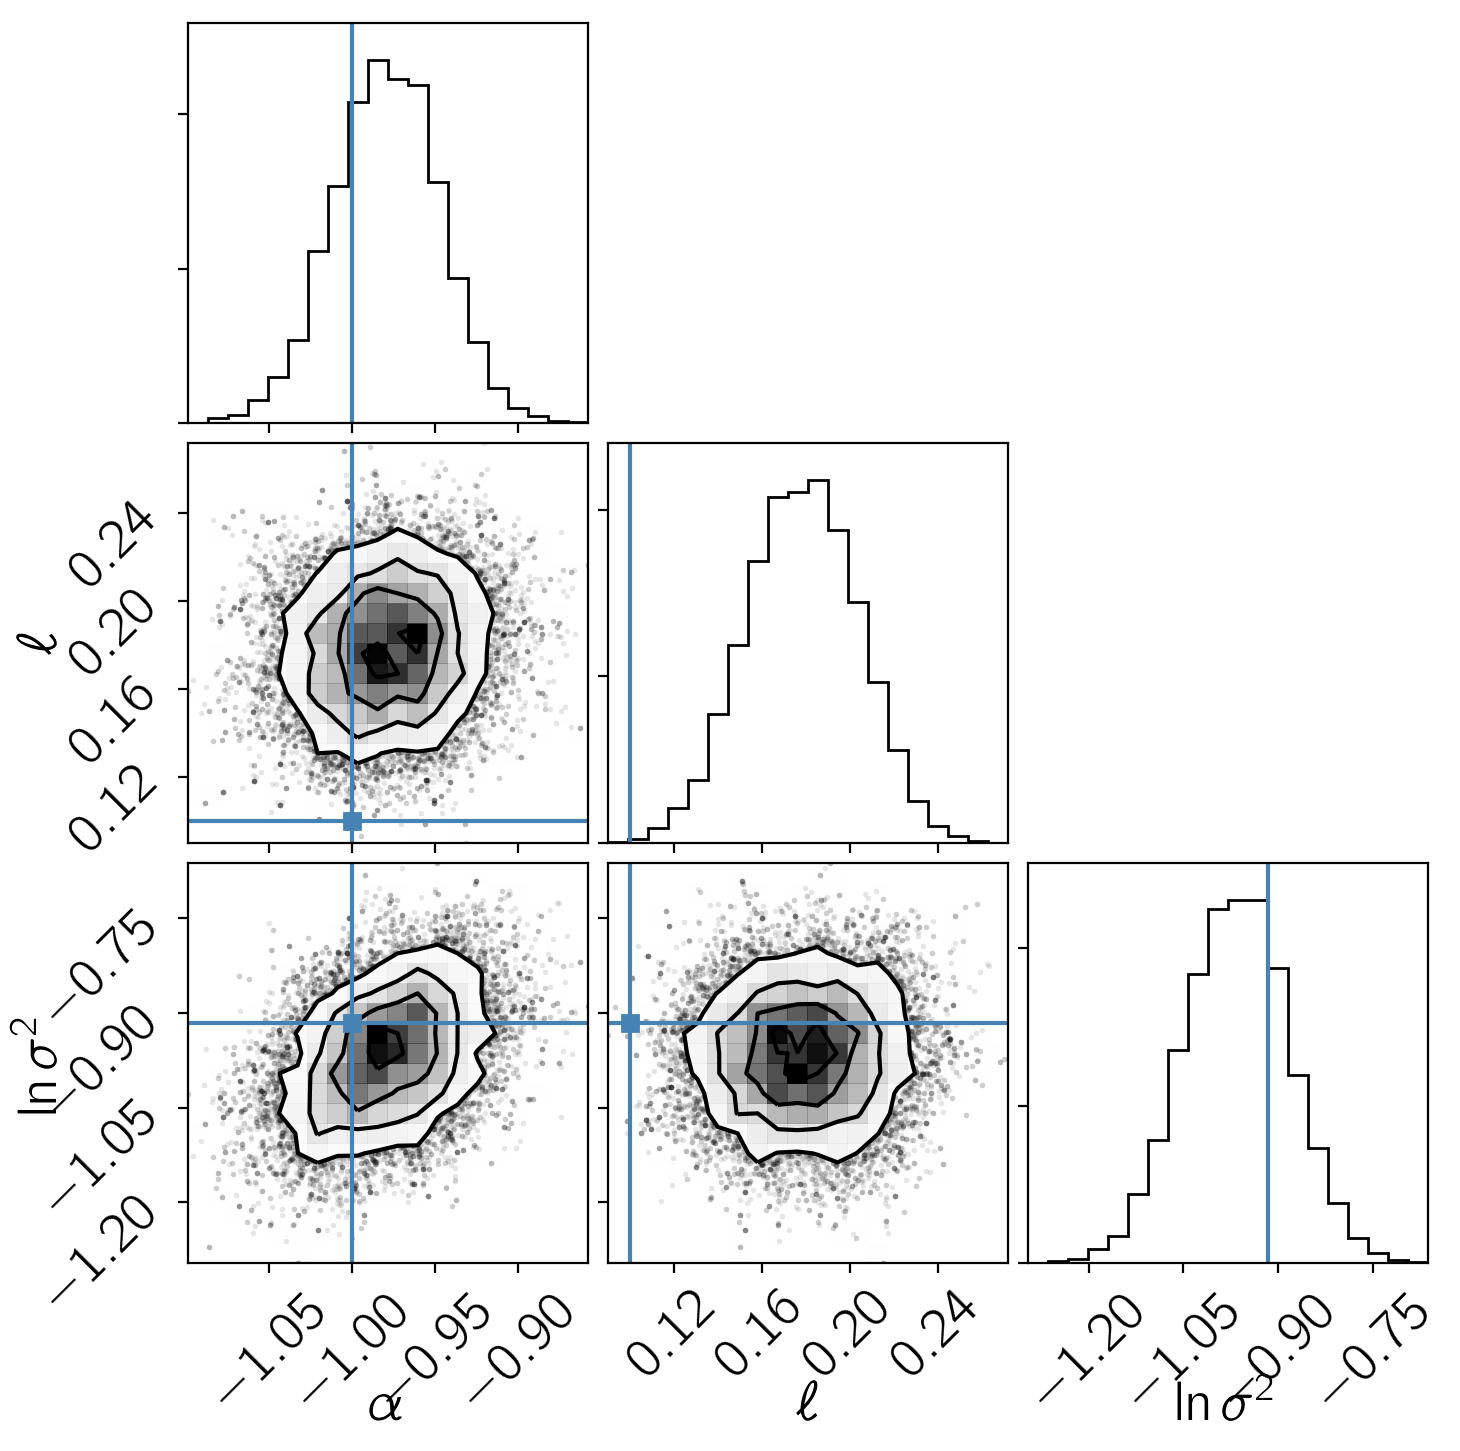

In [9]:
import corner

tri_cols = ["amp", "location", "log_sigma2"]
tri_labels = [r"$\alpha$", r"$\ell$", r"$\ln\sigma^2$"]
tri_truths = [truth[k] for k in tri_cols]
tri_range = [(-2, -0.01), (-3, -0.5), (-1, 1)]
names = model.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

In this figure, the blue lines are the true values used to simulate the data
and the black contours and histograms show the posterior constraints.
The constraints on the amplitude $\alpha$ and the width $\sigma^2$
are consistent with the truth but the location of the feature $\ell$ is
*almost completely inconsistent with the truth!*
This would matter a lot if we were trying to precisely measure radial
velocities or transit times.

## Modeling the Noise

**Note:** A full discussion of the theory of Gaussian processes is beyond the scope of this demo—you should probably check out [Rasmussen & Williams (2006)](http://www.gaussianprocess.org/gpml/)—but I'll try to give a quick qualitative motivation for our model.

In this section, instead of assuming that the noise is white, we'll generalize
the likelihood function to include covariances between data points.
To do this, let's start by re-writing the likelihood function from the
previous section as a matrix equation (if you squint, you'll be able to work
out that we haven't changed it at all):

$$
    \ln p(\{y_n\}\,|\,\{t_n\},\,\{\sigma_n^2\},\,\theta) =
        -\frac{1}{2}\,\boldsymbol{r}^\mathrm{T}\,K^{-1}\,\boldsymbol{r}
        -\frac{1}{2}\,\ln\det K - \frac{N}{2}\,\ln 2\pi
$$

where

$$
    \boldsymbol{r} = \left ( \begin{array}{c}
        y_1 - f_\theta(t_1) \\
        y_2 - f_\theta(t_2) \\
        \vdots \\
        y_N - f_\theta(t_N) \\
    \end{array}\right)
$$

is the residual vector and

$$
    K = \left ( \begin{array}{cccc}
        \sigma_1^2 & 0 & & 0 \\
        0 & \sigma_2^2 & & 0 \\
          & & \ddots & \\
        0 & 0 & & \sigma_N^2 \\
    \end{array}\right)
$$

is the $N \times N$ data covariance matrix (where :math:`N` is the
number of data points).

The fact that $K$ is diagonal is the result of our earlier assumption
that the noise was white.
If we want to relax this assumption, we just need to start populating the
off-diagonal elements of this covariance matrix.
If we wanted to make every off-diagonal element of the matrix a free
parameter, there would be too many parameters to actually do any inference.
Instead, we can simply *model* the elements of this array as

$$
    K_{ij} = \sigma_i^2\,\delta_{ij} + k(t_i,\,t_j)
$$

where $\delta_{ij}$ is the [Kronecker_delta](http://en.wikipedia.org/wiki/Kronecker_delta) and $k(\cdot,\,\cdot)$
is a covariance function that we get to choose.
[Chapter 4](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf) of
Rasmussen & Williams discusses various choices for $k$ but for this
demo, we'll just use the [Matérn-3/2 function](http://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function):

$$
    k(r) = a^2 \, \left( 1+\frac{\sqrt{3}\,r}{\tau} \right)\,
                    \exp \left (-\frac{\sqrt{3}\,r}{\tau} \right )
$$

where $r = |t_i - t_j|$, and $a^2$ and $\tau$ are the
parameters of the model.


## The Final Fit

Now we could go ahead and implement the ln-likelihood function that we came up
with in the previous section but that's what George is for, after all!
To implement the model from the previous section using George, we can write
the following ln-likelihood function in Python:


In [10]:
gp = george.GP(np.var(y) * kernels.Matern32Kernel(10.0), mean=Model(**truth),
               solver=george.HODLRSolver)
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()

As before, let’s run MCMC on this model:

In [11]:
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running first burn-in...
Running second burn-in...
Running production...


You’ll notice that this time I’ve run two burn-in phases. Before the second burn-in, I re-sample the positions of the walkers in a tiny ball around the position of the best walker in the previous run. I found that this re-sampling step was useful because otherwise some of the walkers started in a bad part of parameter space and took a while to converge to something reasonable.

The plotting code for the results for this model is similar to the code in the previous section. First, we can plot the posterior samples on top of the data:

/Users/dfm/research/projects/george/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


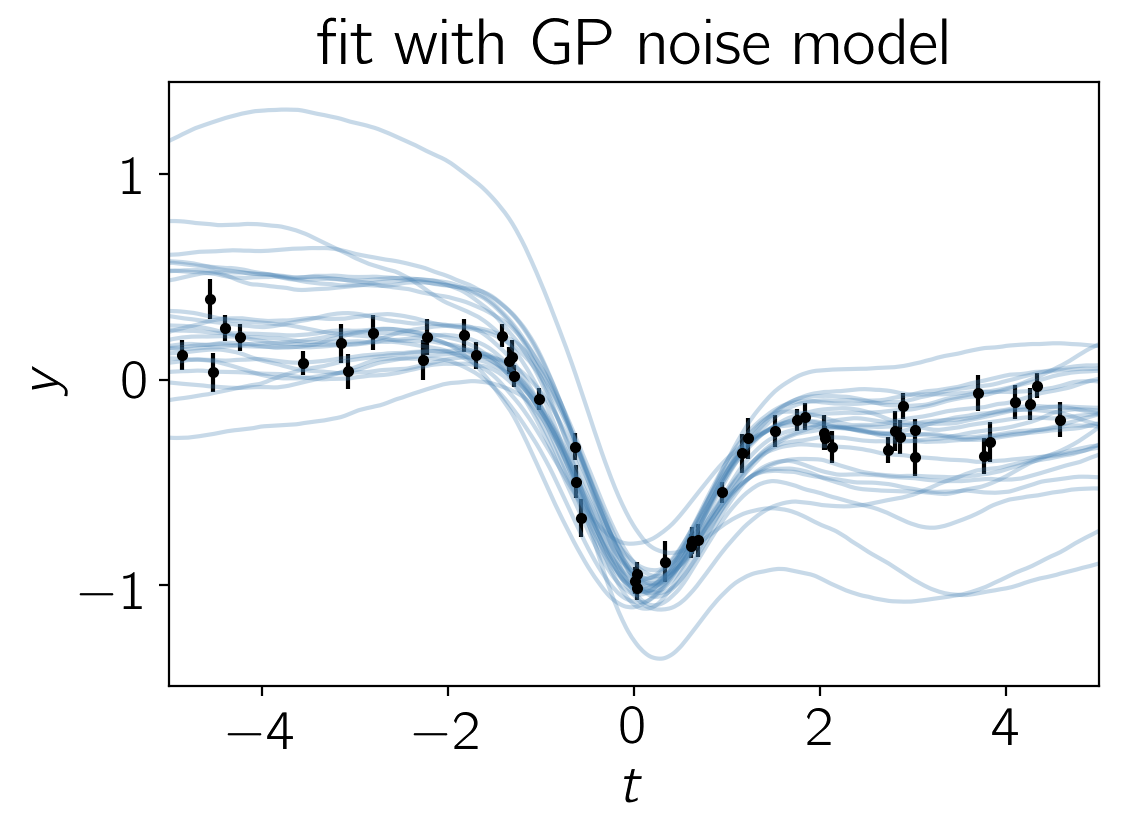

In [74]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

gp2 = george.GP(kernel=gp.kernel, mean=gp.mean)
gp2.compute(t, yerr)

gp3 = george.GP(kernel=gp.kernel, mean=gp.mean, solver=george.HODLRSolver, tol=1e-4)
gp3.compute(t, yerr)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp1.set_parameter_vector(s)
    gp1.compute(t, yerr)
#     print(gp.kernel)
#     print(gp.mean.get_parameter_dict())
#     mu, var = gp3.predict(y, x, return_var=True)
#     std = np.sqrt(var)
#     print(gp.get_parameter_dict())
#     print(gp.solver.apply_inverse(np.array(y)).flatten() - gp2.solver.apply_inverse(np.array(y)).flatten())
    mu = gp1.sample_conditional(y, x)
    pl.plot(x, mu, color="#4682b4", alpha=0.3)
#     pl.fill_between(x, mu+std, mu-std, color="#4682b4", alpha=0.3)
    
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("fit with GP noise model");

In [41]:
yerr

array([ 0.07289058,  0.09602013,  0.09395346,  0.06263079,  0.06740044,
        0.05912944,  0.0950898 ,  0.08532641,  0.08633292,  0.09500439,
        0.08895819,  0.07995774,  0.06455626,  0.05756976,  0.06675873,
        0.08287759,  0.05366713,  0.05275032,  0.06615974,  0.07952409,
        0.09269493,  0.06435312,  0.05865336,  0.05670106,  0.09973269,
        0.05897489,  0.06587734,  0.07841457,  0.05046743,  0.09503243,
        0.09886207,  0.07784473,  0.05423869,  0.06665012,  0.08642143,
        0.05712177,  0.07762345,  0.06365216,  0.09872476,  0.08338935,
        0.06278266,  0.05541557,  0.08880904,  0.0891239 ,  0.0880802 ,
        0.09572016,  0.08293114,  0.07841838,  0.06008778,  0.08491482])

In [65]:
gp._alpha - gp3._alpha

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [64]:
gp3._alpha

array([ -1.28345234e+01,   2.19230085e+01,  -1.74313283e+01,
         1.64467420e+01,   5.30103752e+00,  -1.75764934e+01,
         4.12049738e+00,  -1.38683552e+01,   1.01361957e+01,
        -8.06138175e+00,   4.99569186e+00,   8.98124630e+00,
        -6.90244643e+00,   3.41110510e+01,   1.96603218e+00,
         5.94604544e+00,  -1.76888361e+01,  -1.31534206e+01,
         1.59810413e+01,  -1.29516062e+01,  -2.42705592e+01,
         1.17114661e+01,   5.09868585e+00,   2.75166641e+01,
         8.44745604e+00,  -1.73927630e+01,  -8.75196257e+00,
        -1.54286604e+01,  -2.56216406e+01,   1.91973549e+00,
         6.54232585e+00,   5.09148078e+00,   2.22055427e+01,
         1.74106666e+01,   2.82458862e-02,  -7.67407016e+00,
        -1.13395153e+01,  -2.05522405e+01,   9.38727008e-01,
        -3.34289400e+00,   3.26753714e+01,   1.14611878e+00,
        -1.62785572e+01,   1.69825338e+01,  -2.32310574e+01,
        -1.30378819e+01,   5.91468030e+00,   1.90342203e+00,
         2.54127708e+01,

In [63]:
gp2._alpha - gp._alpha

array([ 0.98970186,  0.35985377,  0.34832498,  0.588804  ,  0.27734697,
       -0.78441559, -0.2379608 , -0.24851256, -0.02302434,  0.28684281,
        0.34518302,  0.53554226,  0.78205896,  0.6793815 ,  0.41391292,
        0.23340265,  0.5259487 ,  0.00633373, -0.14039594, -0.09425212,
       -0.06100303,  0.14657368,  0.15936824,  0.16933619, -0.14993609,
       -1.06777105, -0.85880557, -0.65665638, -1.55572652, -0.29282512,
       -0.21490312,  0.02636745,  0.37020403,  0.24695313,  0.06925346,
        0.15468078,  0.02984387, -0.40390662, -0.17936404, -0.26363667,
       -0.48013516, -0.70790441, -0.27641119, -0.27972318, -0.25286507,
       -0.17790468,  0.03924612,  0.24688347,  0.5963415 ,  0.5470535 ])

In [62]:
gp3.compute(t, yerr)
gp3.predict(y, x, return_cov=False)

array([  5.06028969e-02,   5.09765664e-02,   5.13525511e-02,
         5.17308591e-02,   5.21114981e-02,   5.24944759e-02,
         5.28798001e-02,   5.32674771e-02,   5.36567782e-02,
         5.40449697e-02,   5.44289784e-02,   5.48057300e-02,
         5.51721479e-02,   5.55251524e-02,   5.58616608e-02,
         5.61785859e-02,   5.64728361e-02,   5.67413140e-02,
         5.69809162e-02,   5.71885328e-02,   5.73610461e-02,
         5.74953306e-02,   5.75883006e-02,   5.76389768e-02,
         5.76492231e-02,   5.76194514e-02,   5.75477421e-02,
         5.74319916e-02,   5.72700866e-02,   5.70599030e-02,
         5.67993084e-02,   5.64871633e-02,   5.61248594e-02,
         5.57141738e-02,   5.52568728e-02,   5.47547120e-02,
         5.42094370e-02,   5.36227836e-02,   5.29964904e-02,
         5.23328014e-02,   5.16346481e-02,   5.09050034e-02,
         5.01468330e-02,   4.93630958e-02,   4.85567449e-02,
         4.77307282e-02,   4.68879884e-02,   4.60314647e-02,
         4.51640924e-02,

In [29]:
gp.predict(y, x, return_cov=False) - gp2.predict(y, x, return_cov=False)

array([-0.17055725, -0.17155833, -0.17256188, -0.17356782, -0.17457611,
       -0.17558668, -0.17659947, -0.17761442, -0.17863079, -0.17964599,
       -0.18065709, -0.1816612 , -0.18265539, -0.18363674, -0.18460233,
       -0.18554923, -0.18647451, -0.18737521, -0.18824839, -0.18909109,
       -0.18990035, -0.19067319, -0.19140739, -0.19210498, -0.19277122,
       -0.19340999, -0.19402286, -0.19461122, -0.19517647, -0.19571999,
       -0.19624317, -0.19674841, -0.19724076, -0.19772567, -0.19820832,
       -0.19869047, -0.19917152, -0.19965081, -0.20012768, -0.20060178,
       -0.20107329, -0.20154241, -0.20200934, -0.20247431, -0.20293749,
       -0.2033991 , -0.20385924, -0.20431712, -0.20477152, -0.20522122,
       -0.20566498, -0.20610155, -0.20652971, -0.20694819, -0.20735576,
       -0.20775115, -0.20813311, -0.20850038, -0.20885167, -0.20918577,
       -0.20950279, -0.2098045 , -0.21009273, -0.21037051, -0.21064454,
       -0.21092221, -0.21121069, -0.21151475, -0.21183773, -0.21

In [25]:
gp2.predict(y, x, return_cov=False)

array([  1.78230503e-01,   1.78795703e-01,   1.79353518e-01,
         1.79903736e-01,   1.80446140e-01,   1.80980509e-01,
         1.81506619e-01,   1.82024241e-01,   1.82532463e-01,
         1.83028520e-01,   1.83509329e-01,   1.83971803e-01,
         1.84412847e-01,   1.84829362e-01,   1.85218239e-01,
         1.85576363e-01,   1.85900611e-01,   1.86187848e-01,
         1.86434931e-01,   1.86638706e-01,   1.86796008e-01,
         1.86903660e-01,   1.86958522e-01,   1.86959590e-01,
         1.86908749e-01,   1.86806463e-01,   1.86650909e-01,
         1.86440078e-01,   1.86171947e-01,   1.85844481e-01,
         1.85455630e-01,   1.85004372e-01,   1.84492300e-01,
         1.83921406e-01,   1.83293665e-01,   1.82611042e-01,
         1.81875482e-01,   1.81088923e-01,   1.80253298e-01,
         1.79371072e-01,   1.78445430e-01,   1.77479596e-01,
         1.76476786e-01,   1.75440205e-01,   1.74373047e-01,
         1.73278500e-01,   1.72159744e-01,   1.71019952e-01,
         1.69862289e-01,

In [20]:
gp.get_parameter_dict()

OrderedDict([('mean:amp', -0.89532215251215364),
             ('mean:location', 0.045778851626806429),
             ('mean:log_sigma2', -1.3279344678537952),
             ('kernel:k1:log_constant', -1.3287400920006425),
             ('kernel:k2:metric:log_M_0_0', 3.3983751214960485)])

In [21]:
gp2.get_parameter_dict()

OrderedDict([('mean:amp', -0.89532215251215364),
             ('mean:location', 0.045778851626806429),
             ('mean:log_sigma2', -1.3279344678537952),
             ('kernel:k1:log_constant', -1.3287400920006425),
             ('kernel:k2:metric:log_M_0_0', 3.3983751214960485)])

In [ ]:
yerr

In [ ]:
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain);

In [ ]:
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

It is clear from this figure that the constraints obtained when modeling the noise are less precise (the error bars are larger) but more accurate (and honest).

In [71]:
params = dict([('amp', -0.9084520230247749),
               ('location', 0.014424970078361431),
               ('log_sigma2', -0.91748937072607739)])
kernel = kernels.ConstantKernel(log_constant=-2.826564897326464)
kernel *= kernels.Matern32Kernel(7.369719781508781)
gp1 = george.GP(kernel, mean=Model(**params), solver=george.HODLRSolver)
gp0 = george.GP(kernel, mean=Model(**params))

# p = np.array([-0.89532215,  0.04577885, -1.32793447, -1.32874009,  3.39837512])
p = samples[-100]
gp1.set_parameter_vector(p)
gp0.set_parameter_vector(p)
gp.set_parameter_vector(p)

gp1.compute(t, yerr)
gp0.compute(t, yerr)
x = np.linspace(-5, 5, 500)

for _ in range(10):
    alpha0 = gp0.apply_inverse(y)
    alpha = gp.apply_inverse(y)
    assert np.allclose(alpha, alpha0)

for _ in range(10):
    mu0, cov0 = gp0.predict(y, x)
    mu, cov = gp1.predict(y, x)
    assert np.allclose(mu, mu0)
